In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [15]:
df_final = pd.read_csv("cleaned_fraud_data.csv")
df_final.head()

,category,amt,gender,dob,transaction_hour,is_fraud
0,13,8.49,0,69,22,1
1,10,4.37,1,25,16,0
2,8,738.31,0,54,16,1
3,12,795.01,1,30,23,1
4,7,64.94,0,54,16,0


In [16]:
X = df_final[['category', 'amt', 'gender', 'dob', 'transaction_hour']]
y = df_final[['is_fraud']]

print("Shape of independent variables table:", X.shape)
print("Shape of target variable table:", y.shape)

Shape of independent variables table: (19302, 5)
Shape of target variable table: (19302, 1)


## Comparing 8 classifiers using lazypredict

In [17]:
!pip install lazypredict 

In [18]:
import lazypredict 
from lazypredict import Supervised 
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10,5)

# train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, random_state=12)

In [19]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     random_state=12,
                     classifiers='all',
                    )
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


In [20]:
models.head(8)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.98,0.98,0.98,0.98,0.14
RandomForestClassifier,0.98,0.98,0.98,0.98,0.74
XGBClassifier,0.97,0.97,0.97,0.97,0.42
ExtraTreesClassifier,0.97,0.97,0.97,0.97,0.55
BaggingClassifier,0.97,0.97,0.97,0.97,0.16
DecisionTreeClassifier,0.97,0.97,0.97,0.97,0.05
ExtraTreeClassifier,0.95,0.95,0.95,0.95,0.02
KNeighborsClassifier,0.94,0.94,0.94,0.94,0.27


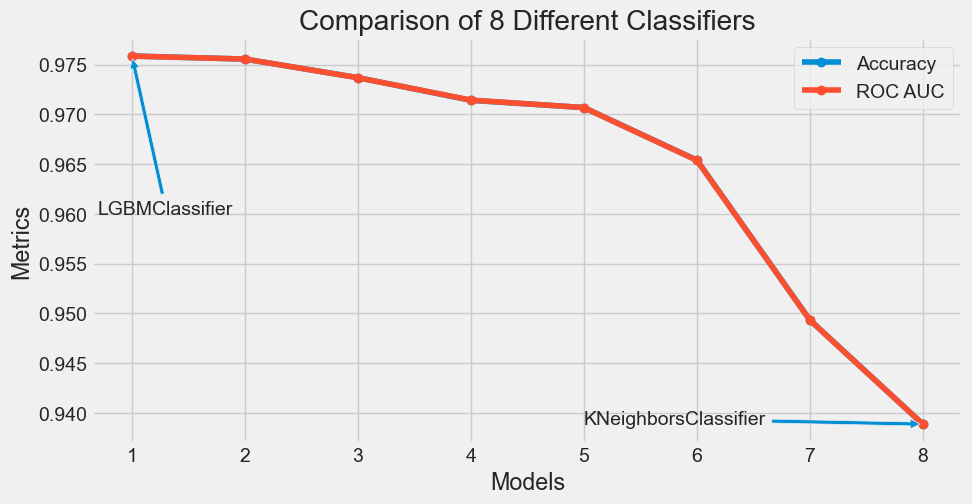

In [21]:
idx = [i for i in range(1,28)]
plt.plot(idx[0:8], models["Accuracy"][0:8]  ,marker='o' , label = "Accuracy" )
plt.plot(idx[0:8], models["ROC AUC"][0:8] , marker ='o' , label = "ROC AUC")
plt.annotate(models.index[0] , 
             (1, models["Accuracy"][0]) , 
             xytext = (0.7, 0.96),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.annotate(models.index[7] , 
             (8, models["Accuracy"][7]) , 
             xytext = (5, models["Accuracy"][7]),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Comparison of 8 Different Classifiers")
plt.legend()
plt.show()

## XGBOOST Classifier

In [22]:
import xgboost as xgb
my_model = xgb.XGBClassifier()
my_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [23]:
import sklearn.metrics as metrics
y_pred = my_model.predict_proba(X_valid)[:,1]
print("ROC AUC before parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.997144163198331


In [24]:
from sklearn.metrics import accuracy_score

y_pred = my_model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

# Evaluate predictions
accuracy_score(y_valid, y_pred)

0.9736814837840638

### Hyper-Parameter Tuning

In [15]:
# For hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9244637861361517                                     
SCORE:                                                                            
0.9219769972023625                                                                
SCORE:                                                                            
0.9174178841570821                                                                
SCORE:                                                                            
0.913066003522951                                                                 
SCORE:                                                                            
0.9243601699305771                                                                
SCORE:                                                                            
0.9245674023417263                                                                
SCORE:                                                    

In [16]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.826100671264752, 'gamma': 1.271799394974182, 'max_depth': 3.0, 'min_child_weight': 2.0, 'reg_alpha': 42.0, 'reg_lambda': 0.3682570109414159}


In [27]:
tuned_xgb = xgb.XGBClassifier(colsample_bytree= 0.998807267028738, gamma= 1.321962425893548,max_depth=10, min_child_weight= 0.0, reg_alpha=43.0, reg_lambda= 0.4888063780234211)
tuned_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.998807267028738, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.321962425893548, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=0.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [28]:
y_pred = tuned_xgb.predict(X_valid)
y_pred = [round(value) for value in y_pred]

# Evaluate predictions
accuracy_score(y_valid, y_pred)

0.9585535177701793

In [29]:
y_pred = tuned_xgb.predict_proba(X_valid)[:,1]
print("ROC AUC after parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC after parameter tuning: 0.9909551639892283


After comparing ROC AUC of before and after parameter tuning, we can conclude that our model is performing better without tuning and has the best parameters by default.

## LightGBM Classifier

In [30]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [31]:
y_pred = model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9759610403067039

In [32]:
y_pred = model.predict_proba(X_valid)[:,1]
print("ROC AUC before parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9972356600900565


### Hyper-Parameter Tuning of LightGBM Classifier

In [33]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

fit_params = {"early_stopping_rounds":30, "eval_metric" : 'auc', "eval_set" : [(X_valid,y_valid)],
            'eval_names': ['valid'], 'verbose': 100, 'categorical_feature': 'auto'}

test_params = {'num_leaves': sp_randint(6, 50), 'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Parameter defining the number of HP points to be tested
hp_points = 100

# n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(estimator=clf, param_distributions=test_params, 
    n_iter=hp_points, scoring='roc_auc', cv=3, refit=True, random_state=314, verbose=True)

# Optimal parameters
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

clf_sw = lgb.LGBMClassifier(**clf.get_params())
# Set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
               subsample=0.855)

In [34]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc', cv=5, refit=True, verbose=True)

gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[100]	valid's auc: 0.994374
[200]	valid's auc: 0.996063
[300]	valid's auc: 0.996414
[400]	valid's auc: 0.996526
[100]	valid's auc: 0.994619
[200]	valid's auc: 0.996268
[300]	valid's auc: 0.99657
[400]	valid's auc: 0.996747
[500]	valid's auc: 0.996824
[100]	valid's auc: 0.994651
[200]	valid's auc: 0.99626
[300]	valid's auc: 0.996725
[400]	valid's auc: 0.996797
[100]	valid's auc: 0.994594
[200]	valid's auc: 0.996414
[300]	valid's auc: 0.996824
[400]	valid's auc: 0.996974
[100]	valid's auc: 0.99496
[200]	valid's auc: 0.996429
[300]	valid's auc: 0.996715
[400]	valid's auc: 0.996827
[100]	valid's auc: 0.995017
[200]	valid's auc: 0.996213
[300]	valid's auc: 0.99644
[400]	valid's auc: 0.996515
[500]	valid's auc: 0.996565
[600]	valid's auc: 0.996644
[100]	valid's auc: 0.994785
[200]	valid's auc: 0.996401
[300]	valid's auc: 0.996799
[400]	valid's auc: 0.996929
[500]	valid's auc: 0.997003
[100]	valid's auc: 0.994936
[200]	valid's auc: 0

In [35]:
def learning_rate_decay_power(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(0.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

# Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())

# Set optimal parameters
clf_final.set_params(**opt_parameters)

# Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate = learning_rate_decay_power)])

[100]	valid's auc: 0.994591
[200]	valid's auc: 0.99607
[300]	valid's auc: 0.996426
[400]	valid's auc: 0.996515
[500]	valid's auc: 0.996576
[600]	valid's auc: 0.996613
[700]	valid's auc: 0.996628
[800]	valid's auc: 0.996637
[900]	valid's auc: 0.996645
[1000]	valid's auc: 0.99665
[1100]	valid's auc: 0.996657
[1200]	valid's auc: 0.996661
[1300]	valid's auc: 0.996666
[1400]	valid's auc: 0.99667
[1500]	valid's auc: 0.996676
[1600]	valid's auc: 0.996682
[1700]	valid's auc: 0.996686
[1800]	valid's auc: 0.996688


LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
               subsample=0.855)

In [36]:
clf_final

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
               subsample=0.855)

In [37]:
y_pred = clf_final.predict_proba(X_valid)[:,1]
print("ROC AUC after parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC after parameter tuning: 0.9966888260500003


After comparing ROC AUC of before and after parameter tuning, we can conclude that our model is performing better without tuning and has the best parameters by default.

## RandomForest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier() 
clf.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
y_pred = clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9759610403067039

In [40]:
y_pred = clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9967425302805109


## Extra Trees Classifier

**Extremely Randomized Trees Classifier(Extra Trees Classifier)** is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest.

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

ex_clf = ExtraTreesClassifier()
ex_clf.fit(X_train, y_train)

ExtraTreesClassifier()

In [42]:
y_pred = ex_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9724380893171692

In [43]:
y_pred = ex_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9953848933456744


## Decision Tree Classifier

In [44]:
from sklearn.tree import DecisionTreeClassifier
dc_clf = DecisionTreeClassifier()
dc_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [45]:
y_pred = dc_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9665319655994198

In [46]:
y_pred = dc_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9665114290161059


## Bagging Classifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

kfold = model_selection.KFold(n_splits = 3)

# Initialize the base classifier
base_cls = DecisionTreeClassifier()

# no. of base classifier
num_trees = 50
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees)

results = model_selection.cross_val_score(model, X_valid, y_valid, cv = kfold)
results.max()

0.9757538078955549

In [48]:
results.mean()

0.9735778675784893

In [49]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9722308569060201

In [50]:
y_pred = model.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9945208801017517


## ExtraTree Classifier

In [51]:
ex_clf = ExtraTreesClassifier(n_estimators=1)
ex_clf.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=1)

In [52]:
y_pred = ex_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9298518288260283

In [53]:
y_pred = ex_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9298237307334731


## KNeighbors Classifier

In [54]:
from sklearn.neighbors import KNeighborsClassifier

k_clf = KNeighborsClassifier()
k_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [55]:
y_pred = k_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9487099782405968

In [56]:
y_pred = k_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9805100025149298


### Conclusion

After observing and comparing total of 8 different classifiers, we saw that LightGBMClassifier, XGBoost, and RandonForestClassifier are performing approximately similar but LightGBMClassifier is 3 times faster which will boost the performace of our overall system. So we will be using **LightGBMClassifier**.